In [1]:
import os
import json
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import models
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models import Doc2Vec
from gensim.models import TfidfModel
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer
from pprint import pprint
from nltk.tag.stanford import StanfordNERTagger
from gensim.models import CoherenceModel
import time
import py2neo
from py2neo import Node, Relationship
from py2neo import Graph
from nltk.tokenize import  sent_tokenize
from IPython.display import display

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shengyuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data(dir,round):
    StartTime=time.time()
   
    data = []
    data_args = []
    content_list=[]
    title_list=[]
    for i in range(1,6):
        with open(os.path.join(dir,'r%d/%d.json'%(round,i)),'r') as d:
            tem_data = json.load(d)
        data.extend(tem_data['result']['docs'])
    for i in range(len(data)):
        content=data[i]['content']
        title=data[i]['title']
        data_args.append([content,title])
    data_set = [tuple(t) for t in data_args]
    data_set =set(data_set)
    
    for item in data_set:
        content_list.append(item[0])
        title_list.append(item[1])
    
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s')
    return content_list,title_list

def getMyStopWordList(text,st,Type):
    myStops=[]
    ctext=re.sub("[^a-zA-Z]"," ", text)
    t=st.tag(ctext.split())
    for name in t:
        if(name[1]==Type):
            myStops.append(name[0].lower())
    return myStops
def review_to_wordlist(text, myStops,remove_stopwords=True):
             
       
    t = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)#remove http url
    t = re.sub(r'www.\S+','',t)#remove www url
    t = re.sub("[\\w.]*@[\\w.]+", "", t)# remove email and twitter account
    t = re.sub("\\S+.com\\S+",'',t) # remove .com url
    t = re.sub("\\S+.com",'',t) # remove .com url
    t = re.sub("\\S+.COM",'',t) # remove .com url
    t = re.sub("(Politics|Business|World|National|Sport|Entertainment|Lifestyle|Money|Environment|World Cup 2018) (Show|Hide) subsections", "", t)
    t = re.sub("Normal text sizeLarger text sizeVery large text size", "", t)
    t = re.sub("WAtoday", "", t)
    t = re.sub("The Sydney Morning Herald", "", t)
    t = re.sub("(Exclusive|Opinion) Normal text", "", t)
    t = re.sub("[^a-zA-Z]"," ", t)
    t = re.sub("\xa0", " ", t) #remove noise from parsing
    t = re.sub("\ufeff", " ", t) #remove noise from parsing
    
    # 3. Convert words to lower case and split them
    words = t.lower().split()
    #
    # 4. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        
        words = [w for w in words if not w in stops]
        words = [w for w in words if not w in myStops]
    stem_word=[]
    stemmer = WordNetLemmatizer() #PorterStemmer()
    
    for word in words:
      
       
        stem_word.append(stemmer.lemmatize(word))
        
    # 5. Return a list of words
    return stem_word


In [3]:
def KeySentence_with_weight(data, article_number, key_word_list,prob_list,n_words,top_n_sentence,myStops):
    article=data[article_number]
    i=0;
    j=0;
    sentenceList = sent_tokenize(article)
    newList=[]
    resultList=[]
    LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
    #print(article)
    #print(sentenceList)
    all_clean_sentence=[]
    for s in sentenceList:           
  
        #Pre-processing
        processed_sentence = review_to_wordlist(s,myStops)
        
        
        # add tokens to list
        if len(processed_sentence)>= 8:
            all_clean_sentence.append(LabeledSentence1(processed_sentence,[j]))
            j=j+1
            newList.append(sentenceList[i])
        i=i+1
    if j>0:
        sentence_scores=np.zeros(j)
        d2v_model = Doc2Vec(all_clean_sentence, vector_size = 1000, min_count = 1, workers=7, dm = 1, 
                        alpha=0.025, min_alpha=0.001)
        d2v_model.train(all_clean_sentence, total_examples=d2v_model.corpus_count, epochs=100, start_alpha=0.002, end_alpha=-0.016)
        for n in range(0,n_words):
            tokens = key_word_list[1][n].split()
            prob=prob_list[1][n]
            new_vector = d2v_model.infer_vector(tokens)
            sims = d2v_model.docvecs.most_similar([new_vector],topn=j)

            for result in sims:
                if(result[0]<=j):
                    sentence_scores[result[0]]=sentence_scores[result[0]]+prob*result[1]
            #print(all_clean_sentence)
            #print(sentenceList)


        index=np.argsort(sentence_scores)
        if j<top_n_sentence:
            top_n_sentence=j
        for i in range(0,top_n_sentence):
            resultList.append(newList[index[j-i-1]])
    return resultList


In [4]:
def getLDAPerfomance(corpus_tfidf, dictionary,all_content, n_topics,iterations,passes):
    LDA_model = ldamodel.LdaModel(corpus_tfidf, 
                              id2word=dictionary, 
                              num_topics=n_topics,
                              iterations=iterations,
                              random_state=np.random.seed(1),
                            
                              passes=passes,
                              alpha='auto',
                              eta='auto'
                              )
    # a measure of how good the model is. lower the better.
    perplexity=LDA_model.log_perplexity(corpus_tfidf)
    # a measure of how good the model is. higher the better.
    coherence_model_lda = CoherenceModel(model=LDA_model, texts=all_content, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    return perplexity,coherence_score

In [5]:
def getNameFromFile(round):
    StartTime=time.time()
    
    myList=[]
    if round==4:
        file = open('Round4name.txt', 'r') 
     
        for line in file: 
            nameList=line.split(',')
            for name in nameList:
                name=name.strip()
                myList.append(name[1:-1])
    elif round ==3:
        file = open('Round3name.txt', 'r') 
        for line in file: 
            nameList=line.split(',')
            for name in nameList:
                name=name.strip()
                myList.append(name[1:-1])
    elif round ==5:
        file = open('Round3name.txt', 'r') 
        for line in file: 
            nameList=line.split(',')
            for name in nameList:
                name=name.strip()
                myList.append(name[1:-1]) 
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s')
    return myList

In [6]:
def getNameFromClassifier(data,path1,path2):
    # Number of corpus
    l=len(data)
    # Create Stop words
    StartTime=time.time()
    myStops=[]
    st = StanfordNERTagger(path1,path2,encoding='utf-8')
    count=0
    Organization_Name=[]
    for text in data:  
        StopWordList=getMyStopWordList(text,st,'PERSON')
        OrganizationList=getMyStopWordList(text,st,'ORGANIZATION')
        for item in StopWordList:
            myStops.append(item)
        for item in OrganizationList:
            Organization_Name.append(item)  
        count=count+1

    Organization_Name=set(Organization_Name)
    for item in Organization_Name:
        if item in myStops:
            myStops.remove(item)

    EndTime=time.time()
    Manual_StopWords=['royal','commission','ms','mr','per','cent','commissions','c','m','orr','hearing','hear','show','said','u']
    for item in Manual_StopWords:
        myStops.append(item)
    myStops=set(myStops)   
    print("Running Time:",np.round(EndTime-StartTime,2),'s')
    return myStops


In [7]:
def LDA_Analysis(data,myStops):

    # Number of corpus
    l=len(data)
    all_content = []
    #Pre-processing
    for text in data:             
        processed_content = review_to_wordlist(text,myStops)
        # add tokens to list
        all_content.append(processed_content)

    # Prepare LDA 
    dictionary = Dictionary(all_content)
    corpus = [dictionary.doc2bow(text) for text in all_content]

    # TF-IDF
    tfidf_model = TfidfModel(corpus)  # fit model
    corpus_tfidf = tfidf_model[corpus]
    
    # Analysis of LDA model
    # Number of Passes
    print("Passes Analysis")
    StartTime=time.time()
    perplexity_list=[]
    coherence_score_list=[]
    iteration=80
    n_topic=5
    passes_range=np.arange(1,6)
    for passes in passes_range:
        p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n_topic,iteration,passes)
        perplexity_list.append(p)
        coherence_score_list.append(c)
        
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.3   # the amount of height reserved for white space between subplots

    
    plt.figure(1,figsize=(10,10))
    plt.suptitle("Passes", fontsize=16)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    plt.subplot(211)
    plt.plot(passes_range, coherence_score_list)
    plt.xlabel("Num Passes")
    plt.ylabel("Coherence score")
    plt.title('Passes VS Coherence score')
    plt.legend(("coherence_values"), loc='best')
    
    plt.subplot(212)
    plt.plot(passes_range, perplexity_list)
    plt.xlabel("Passes")
    plt.ylabel("perplexity")
    plt.title('Passes VS perplexity')
    plt.legend(("perplexity"), loc='best')
    plt.show()
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s','\n')
    
    # Number of Topic
    print("Number of Topic Analysis")
    StartTime=time.time()
    perplexity_list=[]
    coherence_score_list=[]
    iteration=80
    passes=3
    topic_num_range=np.arange(2,11)
    for n in topic_num_range:
        p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n,iteration,passes)
        perplexity_list.append(p)
        coherence_score_list.append(c)

    plt.figure(2,figsize=(10,10))
    plt.suptitle("Number of Topics", fontsize=16)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    plt.subplot(211)
    plt.plot(topic_num_range, coherence_score_list)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title('Num Topics VS Coherence score')
    plt.legend(("coherence_values"), loc='best')
    

    plt.subplot(212)
    plt.plot(topic_num_range, perplexity_list)
    plt.xlabel("Num Topics")
    plt.ylabel("perplexity")
    plt.title('Num Topics VS perplexity')
    plt.legend(("perplexity"), loc='best')
    plt.show()
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s','\n')
    
    # Number of iteration
    print("Number of Topic Analysis")
    StartTime=time.time()
    perplexity_list=[]
    coherence_score_list=[]
    iteration_range=np.arange(10,200,10)
    passes=3
    n_topic=5
    for iteration in iteration_range:
        p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n_topic,iteration,passes)
        perplexity_list.append(p)
        coherence_score_list.append(c)

    plt.figure(3,figsize=(10,10))
    plt.suptitle("Number of iteration", fontsize=16)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    plt.subplot(211)
    plt.plot(iteration_range, coherence_score_list)
    plt.xlabel("Iteration")
    plt.ylabel("Coherence score")
    plt.title('Iteration VS Coherence score')
    plt.legend(("coherence_values"), loc='best')
    

    plt.subplot(212)
    plt.plot(iteration_range, perplexity_list)
    plt.xlabel("Iteration")
    plt.ylabel("perplexity")
    plt.title('Num Topics VS perplexity')
    plt.legend(("perplexity"), loc='best')
    plt.show()
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s','\n')


In [8]:
def myLDA(data,data_title,myStops,n_topics,n_words,passes,iteration, top_n_sentence,top_n_article,graph):
    StartTime=time.time()
    # Number of corpus
    l=len(data)
    all_content = []
    #Pre-processing
    for text in data:             
        processed_content = review_to_wordlist(text,myStops)
        # add tokens to list
        all_content.append(processed_content)
    # Prepare LDA 
    dictionary = Dictionary(all_content)
    corpus = [dictionary.doc2bow(text) for text in all_content]

    # TF-IDF
    tfidf_model = TfidfModel(corpus)  # fit model
    corpus_tfidf = tfidf_model[corpus]
    LDA_model = ldamodel.LdaModel(corpus_tfidf, 
                              id2word=dictionary, 
                              num_topics=n_topics,
                              iterations=iteration,
                              random_state=np.random.seed(1),# setting random seed to get the same results each time.        
                              passes=passes,
                              alpha='auto',
                              eta='auto'
                             )
    print("Topic word probability")
    print(LDA_model.show_topics())
    print("*******************************************************************************************************\n")
    
    # Finding the topic word list and their coreponding probablity
    x=LDA_model.show_topics(num_topics=n_topics, num_words=n_words,formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
    topics_words_probability=[(tp[0], [wd[1] for wd in tp[1]]) for tp in x]

    all_topics = LDA_model.get_document_topics(corpus_tfidf, per_word_topics=True)
    count=1;
    content_list=[]
    content_num=[]
    topic_list=[]
    prob_list=[]
    tp_words=[]
    title_list=[]
    for doc_topics, word_topics, phi_values in all_topics:
        #print('Document ',count,'\n')
        #print('Document topics:', doc_topics)

        for doc_prob in doc_topics:
            topic_list.append(doc_prob[0])
            prob_list.append(doc_prob[1])
            words=" ".join(topics_words[doc_prob[0]][1])
            tp_words.append(words)

            content_list.append(data[count-1])
            title_list.append(data_title[count-1])
            content_num.append(count-1);
        #print ('Word topics:', word_topics)
        #print ('Phi values:', phi_values)
        #print(" ")
        #print('-------------- \n')
        count=count+1
    
    # Create the table to display the sorted result
    df2 = pd.DataFrame(topic_list,columns=['Topic'])
    df3 = pd.DataFrame(content_list,columns=['Content'])
    df4 =pd.DataFrame(tp_words,columns=['Topic Words'])
    df5 =pd.DataFrame(content_num,columns=['Article Number'])
    df6 =pd.DataFrame(title_list,columns=['Article Title'])
    df1=pd.DataFrame(prob_list,columns=['Probability'])

    df1 = df1.assign(df2=df2.values)
    df1 = df1.assign(df3=df3.values)
    df1=df1.assign(df4=df4.values)
    df1=df1.assign(df5=df5.values)
    myTable = df1.assign(df6=df6.values)
    myTable.columns=['Probability','Topic','Cotent','Topic Words','Article Number','Article Title']
    sortedTable=myTable.sort_values(by=['Topic', 'Probability'],ascending=[True,False])
    

    display(sortedTable)
    
    print("*******************************************************************************************************\n")
    
    
    # Retrieve key sentences
    #Parameter

    
    Hearing_node=Node("Hearings",Round=round)
    graph.create(Hearing_node)

    MyResult={}
    MyResult['Round'+str(round)]={}
    Topic_size=[]
    Topic_label=[]
     
    Topic_color= ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(n_topics)]
    sorted_Topic_size=[]
    sorted_index=[]
    
    # Store the size and sort by descending order
    for i in range(0,n_topics):
        df=sortedTable.loc[sortedTable['Topic'] == i]
        df.reset_index()
        sorted_Topic_size.append(df.shape[0])
    
    sorted_Topic_size.sort(reverse = True)
    
    for i in range(0,n_topics):
        df=sortedTable.loc[sortedTable['Topic'] == i]
        df.reset_index()
        size=df.shape[0]
        index_new=0
        for j in range(0,n_topics):
            if(sorted_Topic_size[j]==size):
                sorted_index.append(index_new)
                break
            index_new=index_new+1

        
    for i in range(0,n_topics):
        df=sortedTable.loc[sortedTable['Topic'] == i]
        df.reset_index()
        Topic_size.append(df.shape[0])
        Topic_index="Topic"+str(sorted_index[i]+1)
        Topic_label.append(Topic_index)
        
        key_words=df.iloc[0,-3]
        Topic_node=Node("Topic",Round=round,Topic_ID=int(sorted_index[i]+1),Key_Words=key_words)
        Relation_Shows=Relationship(Hearing_node,'Shows',Topic_node)
        graph.create(Topic_node)
        graph.create(Relation_Shows)
        
        MyResult['Round'+str(round)][Topic_index]={} 

        for j in range(0,top_n_article):
            article_title=df.iloc[j,-1]
            article_number=df.iloc[j,-2]
            key_words=df.iloc[j,-3]
            key_word_list=topics_words[i] 
            prob_list=topics_words_probability[i] 
            a2=KeySentence_with_weight(data,article_number, key_word_list,prob_list,n_words,top_n_sentence,myStops)

            Article_node=Node("Article",Article_ID= int(article_number),Round=round,Topic_ID=int(i+1),Title=article_title)


            Relation_Retrieves=Relationship(Topic_node,'Retrieves',Article_node)
            graph.create(Article_node)
            graph.create(Relation_Retrieves)

            for item in a2:
                Key_Sentence_node=Node("Key_Sentences",Key_Sentence=item)
                Relation_Provides=Relationship(Article_node,'Provides',Key_Sentence_node)
                graph.create(Key_Sentence_node)
                graph.create(Relation_Provides)

              
            MyResult['Round'+str(round)][Topic_index]['Key Words']=key_words
            MyResult['Round'+str(round)][Topic_index]['Article'+str(article_number)]={}
            MyResult['Round'+str(round)][Topic_index]['Article'+str(article_number)]['Key Setences']=a2
            MyResult['Round'+str(round)][Topic_index]['Article'+str(article_number)]['Title']=article_title

    pprint(MyResult)
    # Plot
    print("Topic distribution")
    explode = np.zeros(n_topics)
    explode[0]=0.1
    plt.figure(4,figsize=(10, 10))
    plt.pie(Topic_size, explode=explode,labels=Topic_label, colors=Topic_color,
        autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Topic distribution')
    plt.show()
    EndTime=time.time()
    print("Running Time:",np.round(EndTime-StartTime,2),'s')
    return MyResult,LDA_model, corpus_tfidf, dictionary

In [9]:
# Loading
# Loading Parameter
dir='/Users/shengyuan/Desktop/Study/CAPSTONE/RoyalCommission' #Data folder path
round=4                                                       #Round number
print("Start to load data")
content,title = load_data(dir,round)
# Number of corpus
l=len(content)
print('Total corpus: ',l)
print("End")
print("-------------------------------------------------------------------------------------------------------\n")




Start to load data
Running Time: 0.3 s
Total corpus:  623
End
-------------------------------------------------------------------------------------------------------



Start to get stop-words
Running Time: 0.0 s
End
-------------------------------------------------------------------------------------------------------

Start to analyze performance of LDA
Passes Analysis


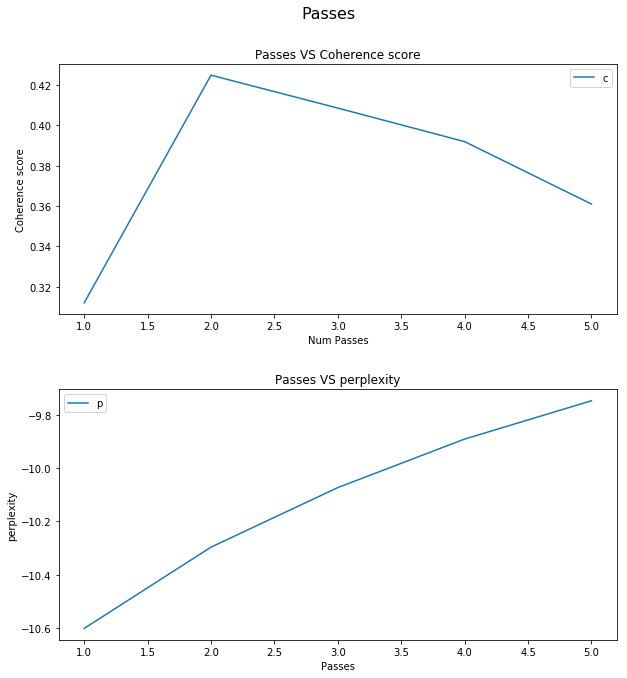

Running Time: 48.25 s 

Number of Topic Analysis


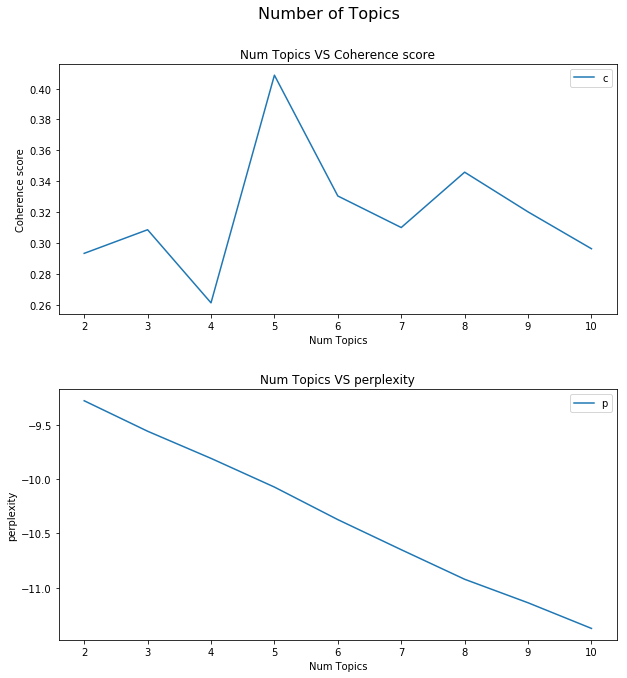

Running Time: 84.18 s 

Number of Topic Analysis


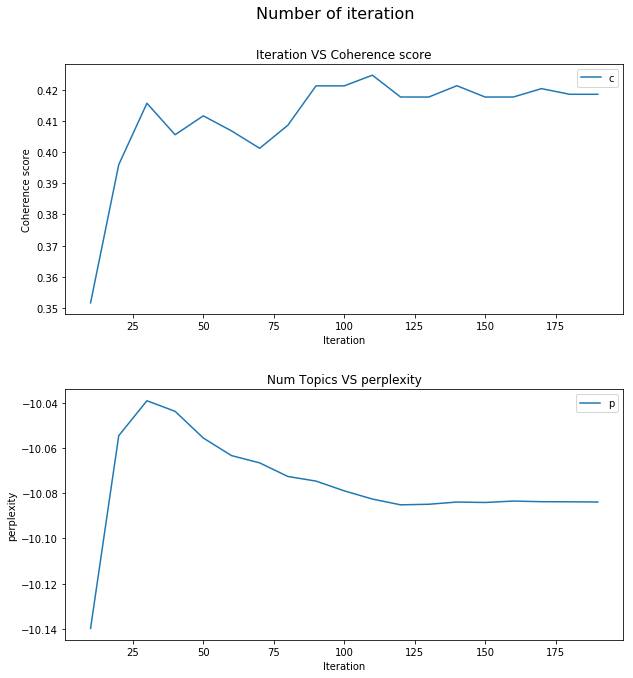

Running Time: 166.93 s 

End
-------------------------------------------------------------------------------------------------------



In [10]:
# Get stop-words
print("Start to get stop-words")
path1='/Users/shengyuan/desktop/study/Capstone/RoyalCommission/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz'
path2='/Users/shengyuan/desktop/study/Capstone/RoyalCommission/stanford-ner-2018-02-27/stanford-ner.jar'
#myStops=getNameFromClassifier(content,path1,path2)
myStops=getNameFromFile(round)
print("End")
print("-------------------------------------------------------------------------------------------------------\n")

# LDA performance
print("Start to analyze performance of LDA")
LDA_Analysis(content,myStops)
print("End")
print("-------------------------------------------------------------------------------------------------------\n")


Start to get themes
Topic word probability
[(0, '0.002*"funeral" + 0.002*"aboriginal" + 0.001*"acbf" + 0.001*"insurance" + 0.001*"property" + 0.001*"policy" + 0.001*"people" + 0.001*"asic" + 0.001*"bank" + 0.001*"insure"'), (1, '0.001*"cba" + 0.001*"mortgage" + 0.001*"broker" + 0.001*"cf" + 0.001*"bank" + 0.001*"management" + 0.001*"rate" + 0.001*"business" + 0.001*"growth" + 0.001*"house"'), (2, '0.001*"cba" + 0.001*"bank" + 0.001*"rural" + 0.001*"business" + 0.001*"amp" + 0.001*"wealth" + 0.001*"share" + 0.001*"blog" + 0.001*"landmark" + 0.001*"u"'), (3, '0.001*"rate" + 0.001*"growth" + 0.001*"mortgage" + 0.001*"price" + 0.001*"bank" + 0.001*"property" + 0.001*"rba" + 0.001*"interest" + 0.000*"farmer" + 0.000*"u"'), (4, '0.001*"bank" + 0.001*"landmark" + 0.001*"property" + 0.001*"cattle" + 0.001*"farm" + 0.001*"rural" + 0.001*"cba" + 0.001*"customer" + 0.001*"million" + 0.001*"sale"')]
***************************************************************************************************

,Probability,Topic,Cotent,Topic Words,Article Number,Article Title
282,0.987628,0,"July 05, 2018 Edition. The big news in Trumpla...",funeral aboriginal acbf insurance property pol...,102,"The Macro View – Health, Financial And Politic..."
1015,0.983743,0,"To submit a letter to The Age, email letters@t...",funeral aboriginal acbf insurance property pol...,378,Penalties and taxes: Cuts are the arithmetic o...
1116,0.983529,0,"To submit a letter to The Age, email letters@t...",funeral aboriginal acbf insurance property pol...,414,"The sporting life: We lost, but we're going in..."
1569,0.981971,0,CONFLICT OF INTEREST A new report from the Aus...,funeral aboriginal acbf insurance property pol...,579,Crikey Worm: Australia’s huge credit card debt...
161,0.981366,0,The culture at Macquarie's stockbroking and fi...,funeral aboriginal acbf insurance property pol...,56,How Macquarie dodged Hayne
173,0.981212,0,"1802 - Proclamation was issued stating: ""His M...",funeral aboriginal acbf insurance property pol...,60,June 30 #OnThisDay in #Australian #History
796,0.981212,0,"ONE NATION, MANY CONTROVERSIES Former One Nati...",funeral aboriginal acbf insurance property pol...,305,Crikey Worm: One Nation’s latest electoral sca...
54,0.981172,0,NSW has delivered a major legislative response...,funeral aboriginal acbf insurance property pol...,21,"July 05, 2018: Clayton Utz: Stop, water thief!..."
517,0.980538,0,GETTING THE GST OF IT Treasurer Scott Morrison...,funeral aboriginal acbf insurance property pol...,192,Crikey Worm: divisions over government’s new G...
648,0.979998,0,Industry super fund-owned bank ME is pleased t...,funeral aboriginal acbf insurance property pol...,252,"July 03, 2018: ME appoints new Chief Informati..."


*******************************************************************************************************



/Users/shengyuan/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'Round4': {'Topic1': {'Article102': {'Key Setences': ['Global debt levels '
                                                       'have reached\xa0a\xa0'
                                                       'new record\xa0of '
                                                       'around\xa0$US200\xa0'
                                                       'trillion including '
                                                       'public and private '
                                                       'debt.',
                                                       '----- '
                                                       'https://www.smh.com.au/business/the-economy/rate-rise-an-even-money-bet-as-inflation-gets-up-off-the-floor-20180628-p4zocs.html '
                                                       'Rate rise an '
                                                       'even-money bet as '
                                                       'inflation gets up of

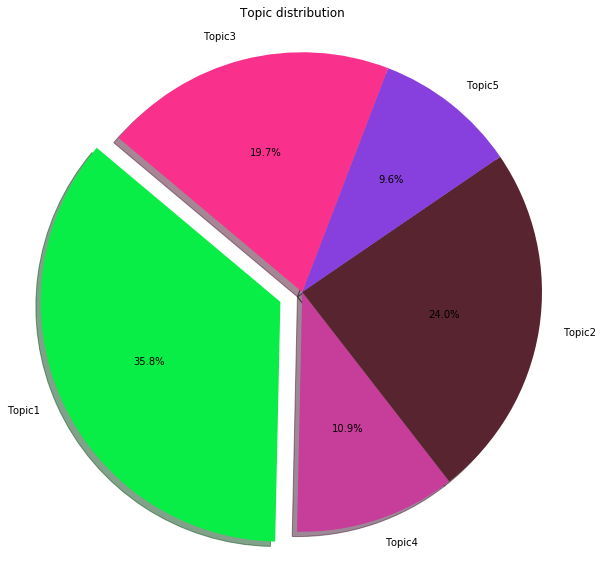

Running Time: 27.36 s
End
-------------------------------------------------------------------------------------------------------



In [11]:
# Optimal Parameter
n_topics=5
n_words=10;
passes=3
iteration=80
top_n_sentence=2
top_n_article=4
graph = Graph(password="123")
print("Start to get themes")
myResult,LDA_model, corpus_tfidf, dictionary=myLDA(content,title,myStops,n_topics,n_words,passes,iteration, top_n_sentence,top_n_article,graph)
print("End")
print("-------------------------------------------------------------------------------------------------------\n")

# Visulization
lda_vis = pyLDAvis.gensim.prepare(LDA_model, corpus_tfidf, dictionary)
pyLDAvis.display(lda_vis)
